In [1]:
import numpy as np
from TMDP import TMDP
from River_swim import River

from algorithms import *
from PG_algorithms import *
from model_functions import *
import gym
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
from PolicyPi import PolicyPi
#np.set_printoptions(precision=4)
import math
from utils import *

nS = 30
nA = 2
seed = get_current_seed()
seed = 44697628841978080856580175700798794719
gamma = .9
mu = np.ones(nS) * 1/nS
river = River(nS, mu, small=5, large=1000, seed=seed)
tau = 1.
xi = np.ones(nS) * 1/nS
tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)


Current seed for result reproducibility: 102202427099198746387266233237249622222


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_pi = PolicyPi(nS, nA).to(device)

In [3]:
tmdp.reset()
tmdp.update_tau(0.25)
opt = torch.optim.Adam(policy_pi.parameters(), lr=1e-3)
cur_res = curriculum_PG(tmdp, policy_pi, opt, episodes=200000, alpha=.25, batch_nS=1, biased=False)

[(0.24418, 0.25), (0.0, 0.24952), (1.0, 0.26483)]
[0.0015509214694395044, 4.405359761060186e-05, -0.13972005513404115]
Updating the policy with alpha_star:  0.24418 tau_star:  0.25
Running episode 1 reward 5.0
[(0.20094, 0.25), (0.0, 0.24947), (1.0, 0.26438)]
[0.002150534110162564, 9.795094751117721e-05, -0.24619058021551465]
Updating the policy with alpha_star:  0.20094 tau_star:  0.25
Running episode 80 reward 5.0
[(0.19367, 0.25), (0.0, 0.24938), (1.0, 0.2645)]
[0.0029574635455548136, 0.00018016844826351333, -0.3437930180627587]
Updating the policy with alpha_star:  0.19367 tau_star:  0.25
Running episode 148 reward 5.0
[(0.16024, 0.25), (0.0, 0.24932), (1.0, 0.26416)]
[0.0023829747507150586, 0.0002648181561627756, -0.4064110856869124]
Updating the policy with alpha_star:  0.16024 tau_star:  0.25
Running episode 160 reward 5.0
[(0.24074, 0.25), (0.0, 0.24919), (1.0, 0.25963)]
[0.002798819542272229, 0.0004308085939570708, -0.20584425096144032]
Updating the policy with alpha_star:  0.

In [4]:
res = bellman_optimal_q(tmdp.env.P_mat, tmdp.env.reward, tmdp.gamma)
Q = res["Q"]

d = compute_d_from_tau(tmdp.env.mu, tmdp.env.P_mat, tmdp.xi, get_policy(Q), tmdp.gamma, 0.)
d_curr = compute_d_from_tau(tmdp.env.mu, tmdp.P_mat_tau, tmdp.xi, get_policy(policy_pi.get_probabilities()), tmdp.gamma, 0.)

print(get_policy(Q) - get_policy(policy_pi.get_probabilities()))

r_s_a = compute_r_s_a(tmdp.env.P_mat, tmdp.env.reward)

j_opt = compute_j(r_s_a, get_policy(Q), d, tmdp.gamma)
j_curr = compute_j(r_s_a, get_policy(policy_pi.get_probabilities()), d_curr, tmdp.gamma)
print("optimal performance: ",j_opt, "curriculum performance: ",j_curr)

[[ 1. -1.]
 [ 1. -1.]
 [ 1. -1.]
 [ 1. -1.]
 [ 1. -1.]
 [ 1. -1.]
 [ 1. -1.]
 [ 1. -1.]
 [ 1. -1.]
 [ 1. -1.]
 [ 1. -1.]
 [ 1. -1.]
 [ 1. -1.]
 [ 1. -1.]
 [ 1. -1.]
 [ 1. -1.]
 [ 1. -1.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
optimal performance:  115.03225818530888 curriculum performance:  101.74636062732367


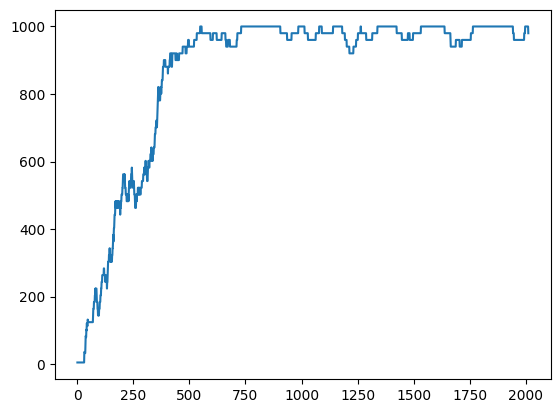

In [5]:
import matplotlib.pyplot as plt
reward_records = cur_res["reward_records"]
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
# Plot
#plt.plot(reward_records)
plt.plot(average_reward)
